In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seawater as csr
from matplotlib import cm

### 比较 oisst and cresm results 

In [3]:
# oisst--> cresm 
# read the oisst into lon2d,lat2d

import pyresample

# #for downloading files
# import urllib2
# read in OISST data 
oisst_nc1=Dataset('20070814120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc')
oisst_nc2=Dataset('20070820120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc')
oisst_lat=oisst_nc1.variables['lat'][:]
oisst_lon=oisst_nc1.variables['lon'][:]
indlat1=np.where(oisst_lat==-9.125)[0][0]
indlat2=np.where(oisst_lat==22.625)[0][0]
indlon1=np.where(oisst_lon==-83.125)[0][0]
indlon2=np.where(oisst_lon==-7.625)[0][0]
oisst_sst1=oisst_nc1.variables['analysed_sst'][0,indlat1:indlat2,indlon1:indlon2]-273.15
oisst_sst2=oisst_nc2.variables['analysed_sst'][0,indlat1:indlat2,indlon1:indlon2]-273.15
oisst_lat1=oisst_lat[indlat1:indlat2]
oisst_lon1=oisst_lon[indlon1:indlon2]
oisst_lon2d, oisst_lat2d = np.meshgrid(oisst_lon1, oisst_lat1)
# Create a pyresample object holding the origin (NCEP) grid:
orig_def = pyresample.geometry.SwathDefinition(lons=oisst_lon2d, lats=oisst_lat2d)

FileNotFoundError: [Errno 2] No such file or directory: b'20070814120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc'

In [10]:
# read in CRESM data 
nc1=Dataset(path1+"/TXGLO.ocn.hi.2007-08-14_21:00:00.nc")
nc2=Dataset(path1+"/TXGLO.ocn.hi.2007-08-20_21:00:00.nc")
lon_curv=nc1.variables['lon_rho'][:]
lat_curv=nc1.variables['lat_rho'][:]
# print(min(lat_curv))

# Create another pyresample object for the target (curvilinear) grid:
targ_def = pyresample.geometry.SwathDefinition(lons=lon_curv, lats=lat_curv)

In [11]:
temp1=nc1.variables["temp"][0,::-1,:,:]
temp2=nc2.variables["temp"][0,::-1,:,:]
salt1=nc1.variables["salt"][0,::-1,:,:]
salt2=nc2.variables["salt"][0,::-1,:,:]

temp1=np.squeeze(temp1)  #删除没有必要的维度
temp2=np.squeeze(temp2)
salt1=np.squeeze(salt1)
salt2=np.squeeze(salt2)
sst1=temp1[0]
sss1=salt1[0]
sst2=temp2[0]
sss2=salt2[0]

In [47]:
# Resample (aka re-project, re-grid) the NCEP data to target grid. First with nearest neighbour resampling...
air_nearest = pyresample.kd_tree.resample_nearest(orig_def, oisst_sst2, \
        targ_def, radius_of_influence=500000, fill_value=None)
# ... then with the custom weight function as inverse of the distance (same as Oleksandr):
wf = lambda r: 1/r**2
air_idw = pyresample.kd_tree.resample_custom(orig_def, oisst_sst2,\
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           weight_funcs=wf, fill_value=None)

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/pyresample/kd_tree.py:382: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0.5,1,'Temp Difference From CRESM Day 21-Day 14')

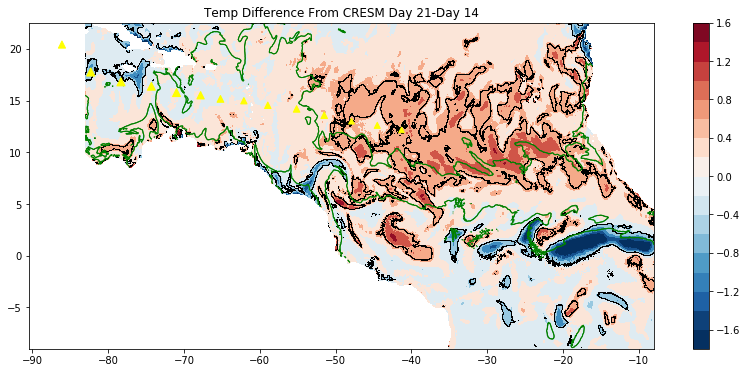

In [68]:
tempd=sst2-sst1
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, tempd, 16, vmin=-1.6, vmax=1.6, cmap=cm.RdBu_r)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.RdBu_r)
m.set_array(tempd)
m.set_clim(-1.6, 1.6)
plt.colorbar(m, boundaries=np.arange(-1.8, 1.8,.2))  #
levels = [35.4,35.41]
cc=ax.contour(lon_curv, lat_curv, sss2, levels, colors='green', linestyles='-', linewidths=1)
levels = [0.49,0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='-', lw=1)
levels = [-0.51,-0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='--', lw=1)
xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
ax.set_title('Temp Difference From CRESM Day 21-Day 14')
# ax.set_title('SST difference between CRESM and OISST on Day 20th  ')

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0.5,1,'SST difference between CRESM and OISST on Day 20th  ')

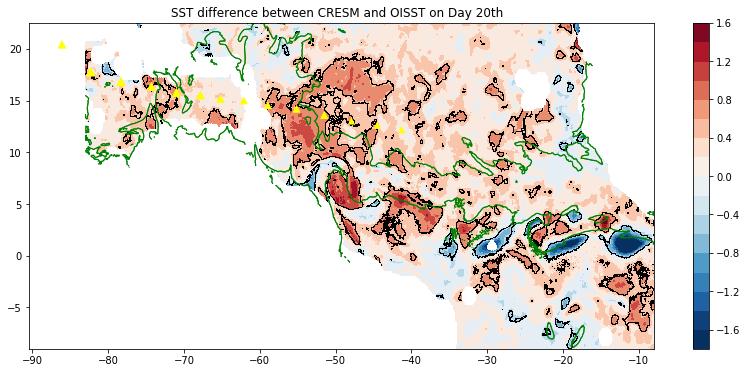

In [67]:
tempd=sst2-air_idw2
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, tempd, 16, vmin=-1.6, vmax=1.6, cmap=cm.RdBu_r)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.RdBu_r)
m.set_array(tempd)
m.set_clim(-1.6, 1.6)
plt.colorbar(m, boundaries=np.arange(-1.8, 1.8,.2))  #

levels = [35.4,35.41]
cc=ax.contour(lon_curv, lat_curv, sss2, levels, colors='green', linestyles='-', linewidths=1)
levels = [0.49,0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='-', linewidth=1)
levels = [-0.51,-0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='--', lw=1)

xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
# ax.set_title('Temp Difference From CRESM Day 21-Day 14')
ax.set_title('SST difference between CRESM and OISST on Day 20th  ')

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/pyresample/kd_tree.py:382: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))
/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0.5,1,'SST difference between CRESM and OISST on Day 14th  ')

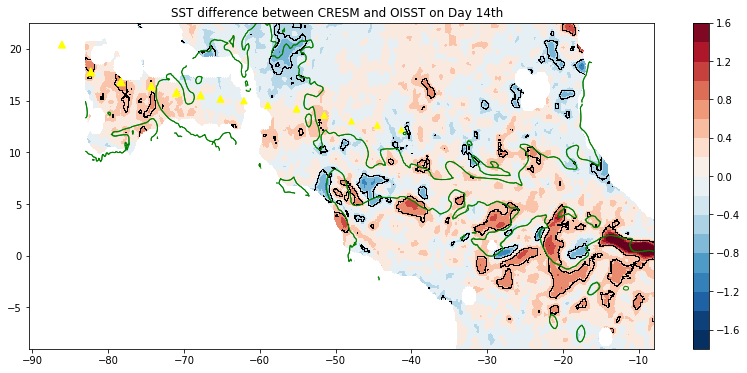

In [66]:
wf = lambda r: 1/r**2
air_idw1 = pyresample.kd_tree.resample_custom(orig_def, oisst_sst1,\
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           weight_funcs=wf, fill_value=None)

tempd=sst1-air_idw1
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, tempd, 16, vmin=-1.6, vmax=1.6, cmap=cm.RdBu_r)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.RdBu_r)
m.set_array(tempd)
m.set_clim(-1.6, 1.6)
plt.colorbar(m, boundaries=np.arange(-1.8, 1.8,.2))  #
levels = [35.4,35.41]
cc=ax.contour(lon_curv, lat_curv, sss1, levels, colors='green', linestyles='-', linewidths=1)

levels = [0.49,0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='-', lw=1)
levels = [-0.51,-0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='--', lw=1)
xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
# ax.set_title('Temp Difference From CRESM Day 21-Day 14')
ax.set_title('SST difference between CRESM and OISST on Day 14th  ')

/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/pyresample/kd_tree.py:382: UserWarning: Possible more than 10 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))
/Network/Servers/csrp.tamu.edu/Volumes/csrp1/Users/xiaoxiaoyu/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0.5,1,'Temp Difference From OISST Day 21-Day 14  ')

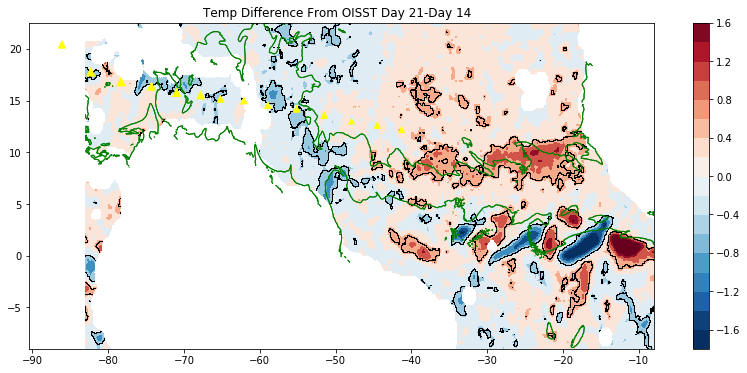

In [65]:
wf = lambda r: 1/r**2
air_idw1 = pyresample.kd_tree.resample_custom(orig_def, oisst_sst1,\
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           weight_funcs=wf, fill_value=None)
air_idw2 = pyresample.kd_tree.resample_custom(orig_def, oisst_sst2,\
                           targ_def, radius_of_influence=500000, neighbours=10,\
                           weight_funcs=wf, fill_value=None)
tempd=air_idw2-air_idw1
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 1, 1)
p = ax.contourf(lon_curv, lat_curv, tempd, 16, vmin=-1.6, vmax=1.6, cmap=cm.RdBu_r)  #cm.nipy_spectral,bwr, RdBu_r , vmin=-2, vmax=2
m = plt.cm.ScalarMappable(cmap=cm.RdBu_r)
m.set_array(tempd)
m.set_clim(-1.6, 1.6)
plt.colorbar(m, boundaries=np.arange(-1.8, 1.8,.2))  #

levels = [35.4,35.41]
cc=ax.contour(lon_curv, lat_curv, sss3, levels, colors='green', linestyles='-', linewidths=1)

levels = [0.49,0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='-', lw=1)
levels = [-0.51,-0.5]
cc=ax.contourf(lon_curv, lat_curv, tempd, levels, colors='k', linestyles='--', lw=1)

xh=[-41.3,-44.5,-47.9,-51.5,-55.14,-58.94,-62.1,-65.19,-67.81,-70.98,-74.3,-78.31,-82.30,-86.10]
yh=[12.16,12.6,13.0,13.58,14.19,14.54,14.98,15.160,15.509,15.77,16.38,16.81,17.76,20.41]
vmax=[31.64,36.24,32.28,43.36,42.87,41.48,40.31,46.14,54.13,64.34,61.70,66.18,66.05,50.95]
s = vmax*5
plt.scatter(xh, yh, s, c="yellow", marker='^',label="Dean track")
# ax.set_title('Temp Difference From CRESM Day 21-Day 14')
ax.set_title('Temp Difference From OISST Day 21-Day 14  ')

### analysis the CRESM results

In [70]:
# analysis the CRESM results
# read multiple files before hurrican came
import os
path1="/localdata/xiaoxiaoyu/CRESM/"
files_1=os.listdir(path1)
files=files_1[:]
def hasNumber(inputString):
    return any(char.isdigit() for char in inputString)   # if there is a digit in a string, and, should start with D
for file in files_1:
    if not hasNumber(file) or not file.startswith('TXGLO.ocn.hi.'):
        files.remove(file)         # remove all the items has no digit 
files_1=files
len(files_1)
files_1

['TXGLO.ocn.hi.2007-08-14_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-15_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-16_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-17_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-18_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-19_21:00:00.nc',
 'TXGLO.ocn.hi.2007-08-20_21:00:00.nc']

In [77]:
nc2=Dataset(path1+"/TXGLO.ocn.hi.2007-08-14_21:00:00.nc")
nc2.set_auto_mask(False)
h,zeta,theta_s,theta_b,hc, N,TYPE,vtran,vstre=get_const(nc2)
z=roms_zlevel(h,zeta,theta_s,theta_b,hc,N,TYPE,vtran=vtran,vstre=vstre)

### plot the one point profile changes with time 

In [124]:
# find the point for what you get interest

# (13.2, 49.5)

lat_0=nc2.variables['lat_rho'][:][:,0]
# np.where(13.1<lat_0<13.3)
for ind, lat in enumerate(lat_0):
    if 13.1<lat<13.3:
        print(ind)
        print(lat)
# -57.044441, 14.284866

268
13.178913668761165
269
13.260052241759094


In [125]:

lon_0=nc2.variables['lon_rho'][:][0,:]
for ind, lon in enumerate(lon_0):
    if -49.4>lon>-49.6:
        print(ind)
        print(lon)

401
-49.583333333333336
402
-49.5
403
-49.41666666666667


In [127]:
lon0=402   #218
lat0=268   #314

temp_f=nc2.variables['temp'][:,::-1,lat0,lon0]
lat_point0=nc2.variables['lat_rho'][lat0,lon0]
lon_point0=nc2.variables['lon_rho'][lat0,lon0]

print(np.shape(temp_f))
z[::-1,0,lat0,lon0][0:14]

(8, 50)


array([  -3.66689003,  -11.08433238,  -18.54049129,  -26.03841268,
        -33.58281726,  -41.18028949,  -48.83954105,  -56.57175926,
        -64.39105421,  -72.31502238,  -80.36544872,  -88.56917486,
        -96.9591673 , -105.57582688])

In [128]:
temp_1=[]
salt_1=[]
for file in files_1:
    if not os.path.isdir(file):
        f=Dataset(path1+"/"+file)
        f.set_auto_mask(False)
        temp_f=f.variables['temp'][:,::-1,lat0,lon0]
        temp_1.append(temp_f)
        salt_f=f.variables['salt'][:,::-1,lat0,lon0]
        salt_1.append(salt_f)
np.shape(salt_1)

(7, 8, 50)

In [130]:
temp_2=np.transpose(np.reshape(temp_1,[56,50]))
salt_2=np.transpose(np.reshape(salt_1,[56,50]))
date=np.arange(14,21,0.125)
temp_3=temp_2[0:14]
salt_3=salt_2[0:14]
press_1=z[::-1,0,lat0,lon0][0:14]

In [131]:
# 计算该点的mixed layer, barrier layer
mld_t2=np.full_like(temp_3[0,:],None)
mld_r2=np.full_like(temp_3[0,:],None)
density_3=np.full_like(temp_3,None)
[rows, cols]=temp_3.shape

for j in range(cols-1):
    mld_t2[j]=mld_temp(temp_3[:,j],press_1)
    density_3[:,j] = csr.dens(salt_3[:,j] , temp_3[:,j] , -1*press_1)
    
for j in range(cols-1):
    mld_r2[j]=mld_density(temp_3[:,j],salt_3[:,j],press_1)

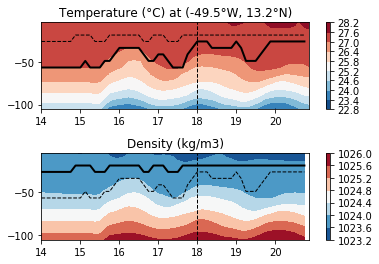

In [132]:
temp=temp_3
salt=salt_3
depth=press_1
hurricane_date=16  #18

fig, (ax1, ax3) = plt.subplots(nrows=2)
Xi, Yi = np.meshgrid(date, depth)

ax1.plot(date, mld_t2, linewidth=2, color='k')
ax1.plot(date, mld_r2, linewidth=1, color='k',linestyle='--')
#  plt.plot(x, y, x, ym1, x, ym2, 'o')   
cntr1=ax1.contourf(Xi, Yi, temp, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax1)

ax1.plot([hurricane_date, hurricane_date], [min(depth), max(depth)], 'k--', lw=1)

ax1.set_title('Temperature (°C) at ('+str(round(lon_point0,1))+'°W, '+str(round(lat_point0,1))+'°N)')

# ax2.plot(date, mld_t2, linewidth=1, color='k',linestyle='--')
# ax2.plot(date, mld_r2, linewidth=2, color='k')
# cntr2 = ax2.contourf(Xi, Yi, salt, cmap="RdBu_r")
# fig.colorbar(cntr2, ax=ax2)
# ax2.plot([18, 18], [min(depth), max(depth)], 'k--', lw=1)
# ax2.set_title('Salinity (psu)')

ax3.plot(date, mld_t2, linewidth=1, color='k',linestyle='--')
ax3.plot(date, mld_r2, linewidth=2, color='k')
cntr3 = ax3.contourf(Xi, Yi, density_3, cmap="RdBu_r")
fig.colorbar(cntr3, ax=ax3)
ax3.plot([hurricane_date, hurricane_date], [min(depth), max(depth)], 'k--', lw=1)
ax3.set_title('Density (kg/m3)')

plt.subplots_adjust(hspace=0.5)
# plt.show()
fig.savefig('foo2.png')

### Function for CRESM, BLT, Plot  etc 

In [76]:
# calculate depth from ROMS output. 
def get_const(nc2):
    h=nc2.variables['h'][:]
    zeta=nc2.variables['zeta'][:]
    theta_s=nc2.variables['theta_s'][0]
    theta_b=nc2.variables['theta_b'][0]
    hc=nc2.variables['hc'][:]
    s_rho=nc2.variables['s_rho'][:]
    N=np.shape(s_rho)[0]
    TYPE='R'
    vtran=nc2.variables['Vtransform'][0]
    vstre=nc2.variables['Vstretching'][0]
    return h,zeta,theta_s,theta_b,hc, N,TYPE,vtran,vstre


In [72]:
def roms_zlevel(h,zeta,theta_s,theta_b,hc, N,type,**kwargs):
        '''
        Z = roms_zlevel(H,ZETA,THETA_S,THETA_B,HC,N,TYPE,**kwargs)
        computes the z-level depth by the input variables. Input variables are:

                H                         :  Bathymetry
                ZETA              :  Surface elevation referred to undisturbance sea level
                THETA_S   :  S-coordinate surface control parameter
                THETA_B   :  S-coordinate bottom  control parameter
                HC                       :  Critical depth (TCLINE) in meters (positive) controlling
                                                        the stretching
                N                         :  Number of vertical level. If TYPE = 'w', Z has N+1 level
                TYPE              :  'r' or 'R' for rho point and 'w' or 'W' for w point

        Z = roms_zlevel(H,ZETA,THETA_S,THETA_B,HC,N,TYPE,vtran=vtran,vstre=vstre)
                **kwargs
                        vtran           :  Vertical transformation equation switch, a numerical 
                                                        value either 1 or 2 (default)
                        vstre           :  Vertical stretching function swith, a numerical value
                                                        from 1 to 4 (default)
        Created by C.Y. Hsu @TAMU, Dept Oceanography, 2013
        '''
        vstre = kwargs.pop('vstre',4)
        vtran = kwargs.pop('vtran',2)
        if type.lower() == 'w': sc = (np.arange(0,N+1.)-N)/N; N=N+1;
        if type.lower() == 'r': sc = (np.arange(1,N+1.)-N-0.5)/N
#--  switch case:  vstre
        if      vstre == 1:
                if theta_s != 0: Cs =(1-theta_b)*np.sinh(theta_s*sc)/np.sinh(theta_s)+\
                                                          theta_b*(-0.5+0.5*np.tanh(theta_s*(sc+0.5))/np.tanh(0.5*theta_s))
                if theta_s == 0: Cs =sc

        elif vstre == 2:
                alpha =1; beta = 1;
                if theta_s > 0:
                        Csur=(1-np.cosh(theta_s*sc))/(np.cosh(theta_s)-1)
                        if theta_b >0:
                                Cbot = -1 +(np.sinh(theta_b*(sc+1)))/np.sinh(theta_b)
                                Cweight=((sc+1)**alpha)*(1+(alpha/beta)*(1-(sc+1)**beta))
                                Cs=Cweight*Csur+(1-Cweight)*Cbot
                        else: Cs=Csur
                else: Cs=sc

        elif vstre == 3:
                alpha=theta_s;beta=theta_b;Hscale=3;
                Csur=-np.log(np.cosh(Hscale*(abs(sc)**alpha)))/np.log(np.cosh(Hscale))
                Cbot= np.log(np.cosh(Hscale*((sc+1)**beta)))  /np.log(np.cosh(Hscale))-1
                Cweight=0.5*(1-np.tanh(Hscale*(sc+0.5)))
                Cs=Cweight*Cbot+(1-Cweight)*Csur

        elif vstre == 4:
                if theta_s > 0:
                        Csur=(1-np.cosh(theta_s*sc))/(np.cosh(theta_s)-1)
                else: Csur=-sc**2
                if theta_b > 0:
                        Cs=(np.exp(theta_b*Csur)-1)/(1-np.exp(-theta_b))
                else: Cs=Csur
#--  end                

#       im,jm = h.shape
#       z = np.zeros((N,im,jm))
        z = []
        if      vtran == 1:
                for k in range(N):
                        z0 = hc*sc[k]+(h-hc)*Cs[k]
                        #z[k,:,:]=z0+zeta*(1.+z0/h)
                        z.append( z0+zeta*(1.+z0/h) )
        elif vtran == 2:
                for k in range(N):
                        z0 = (hc*sc[k]+h*Cs[k])/(hc+h)
                        #z[k,:,:]=zeta+(zeta+h)*z0
                        z.append( zeta+(zeta+h)*z0 )

        z = np.array(z)
        return np.squeeze(z)

In [73]:
# calculate the mld by temperature
def mld_temp(temp, z):
    # default: 10m layer is in the ind=1 layer 
    # ind_10m=np.where((z<-9)&(z>-11))[0][0]
    ind_10m=1
    for index, dep in enumerate(z[ind_10m::]):
        if temp[index+ind_10m]<temp[ind_10m]-0.2:
            return dep
            break

In [74]:
# http://www.ifremer.fr/cerweb/deboyer/mld/Surface_Mixed_Layer_Depth.php 
#calculate density mld

def mld_density(temp,salt,z):
    # temp, salt is 1d, only has the depth
    # default: 10m layer is in the ind=1 layer 
    density_profiles = csr.dens(salt, temp, -1*z)  #the origianl density
    
    # calculate the critical density 
    #ind_10m=np.where((z<-9)&(z>-11))[0][0]
    ind_10m=1
    delta_density=csr.dens(salt[ind_10m], temp[ind_10m]-0.2, 0)-csr.dens(salt[ind_10m], temp[ind_10m], 0)
    density_zero=density_profiles[ind_10m]+delta_density
    rou0=min(density_profiles, key=lambda x:abs(x-density_zero))
    ind=np.argwhere(density_profiles==rou0)
    if ind.size==0:
        return None
    else:
        return z[ind][0][0]